In [1]:
from operator import xor
from utils import *

In [2]:
path_logs = Path('./logs/')
path_simus = Path('./preprocessing/')
path_index = path_simus / 'index.parquet'

In [3]:
from loguru import logger
ordered_levels = ['TRACE' , 'DEBUG', 'INFO', 'WARNING']
set_logger(logger, ordered_levels, path_logs)

In [4]:
ptfo_params = {
    'aum': 100e6,
    'max_leverage': 5,
    # 'leverage': 5,  # does not do what is aimed at
    'min_abs_weight': 1e-4,
    # not convex, could increase the computing time a lot, but, does not in practice
    'weight_bounds': [-0.02, 0.02],
    'prop_adv': 0.02,
    'net_bounds': [-0.01, 0.01],
    'penalizations': {
        'cost_transaction': 1.0,
        'cost_shorting': 1.0,
        'cost_market_impact': 1.0,
    },
}

In [5]:
assert xor('leverage' in ptfo_params, 'max_leverage' in ptfo_params)

# Load signal and market data

In [6]:
# path_preprocessing = max(path_simus.glob('[0-9]*'), key=lambda path: int(path.stem))
path_preprocessing = Path('preprocessing/1576.parquet')

params, weights = read_data_one_preprocessing(path_preprocessing, path_index)
weights = weights.collect()
params

{'formation_length': 126,
 't_max': 63,
 'n_stocks': 10,
 'first_step': 'do_nothing',
 'window': 63,
 'third_step': 'do_nothing',
 'path_preprocessing': 'preprocessing/1576.parquet'}

In [7]:
%%time
weights_n_data = get_data_for_backtest(weights, ptfo_params)

CPU times: user 16.5 s, sys: 3.29 s, total: 19.8 s
Wall time: 2.67 s


# Signals analytics

<Figure size 900x500 with 0 Axes>

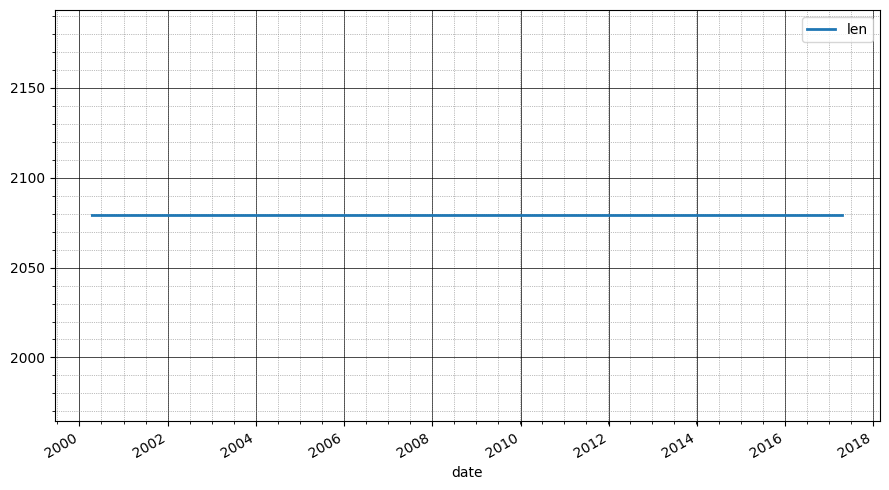

<Figure size 900x500 with 0 Axes>

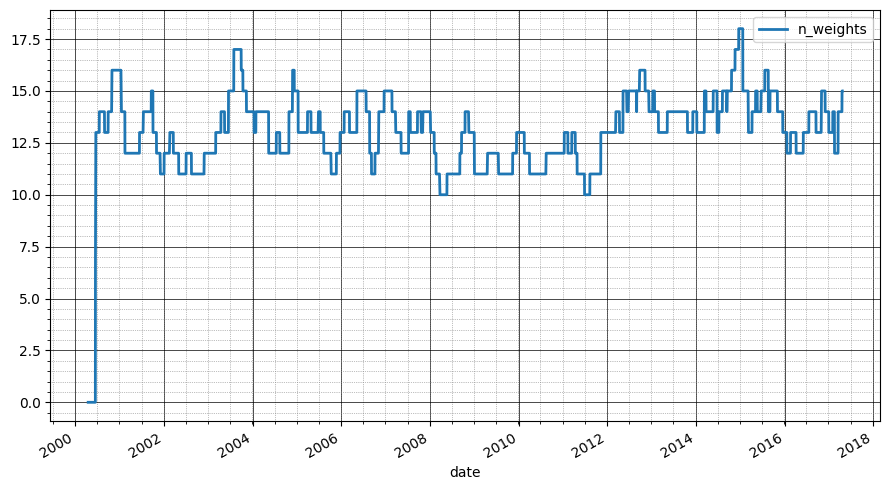

<Figure size 900x500 with 0 Axes>

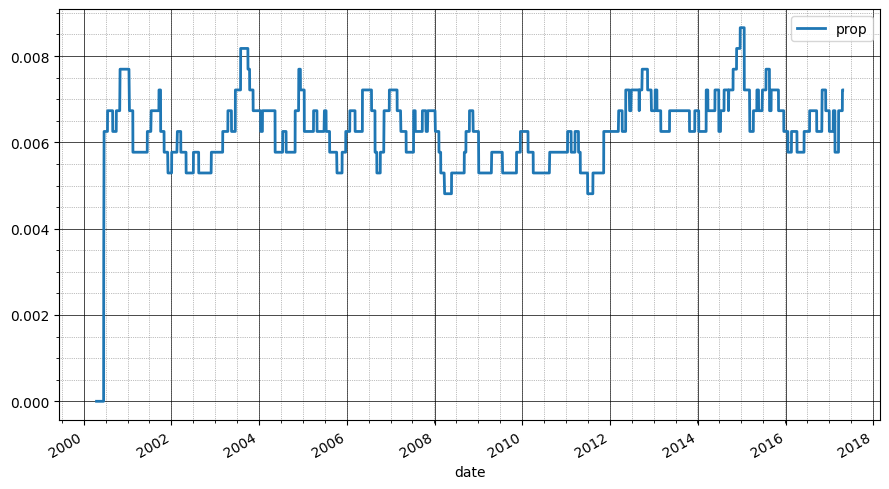

<Figure size 900x500 with 0 Axes>

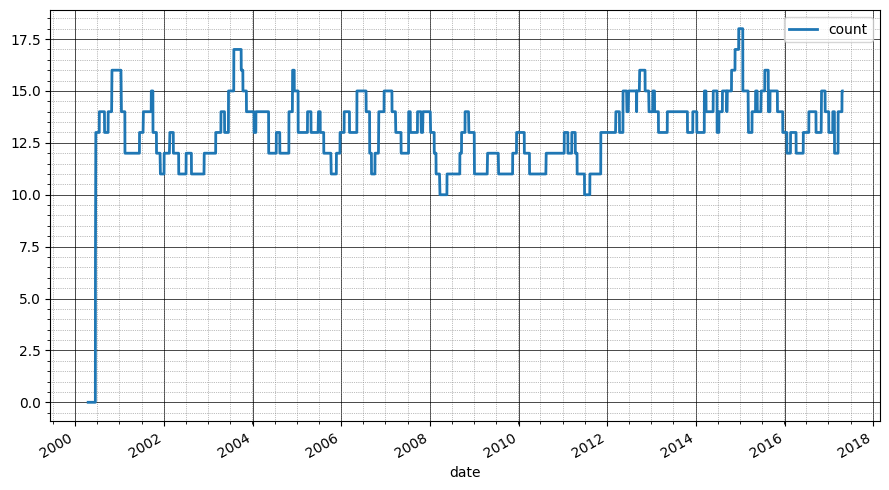

<Figure size 900x500 with 0 Axes>

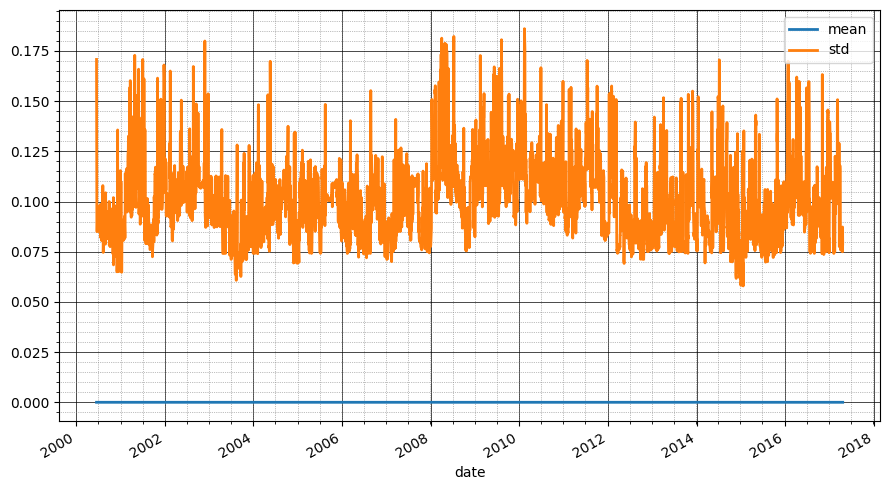

<Figure size 900x500 with 0 Axes>

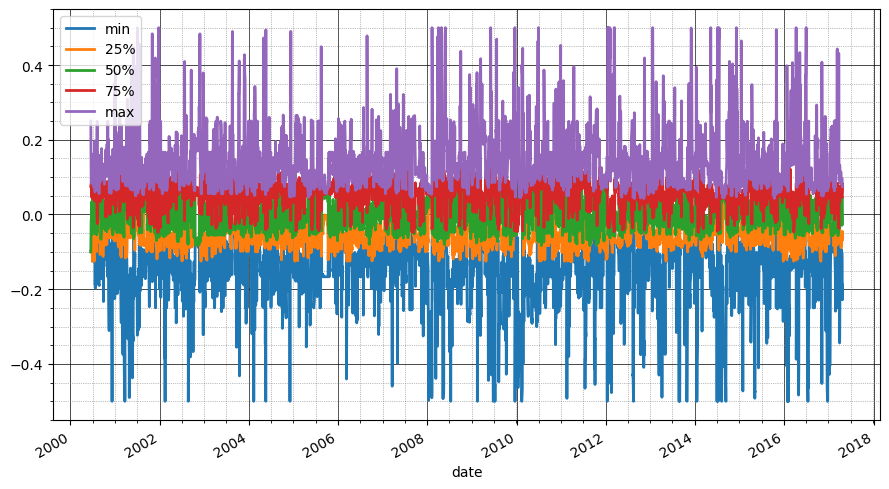

<Figure size 900x500 with 0 Axes>

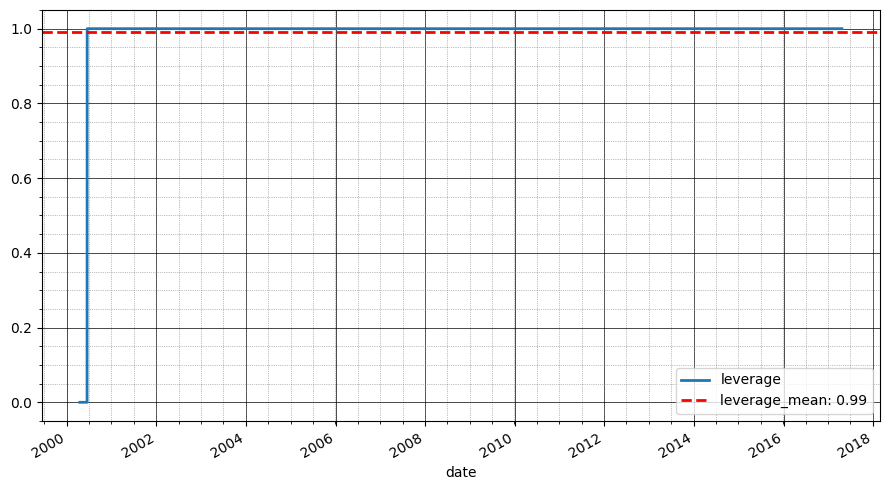

<Figure size 900x500 with 0 Axes>

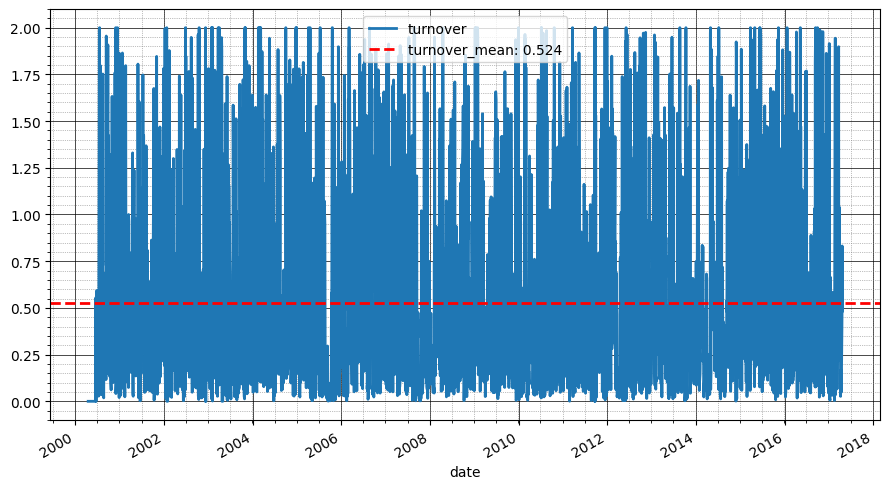

<Figure size 900x500 with 0 Axes>

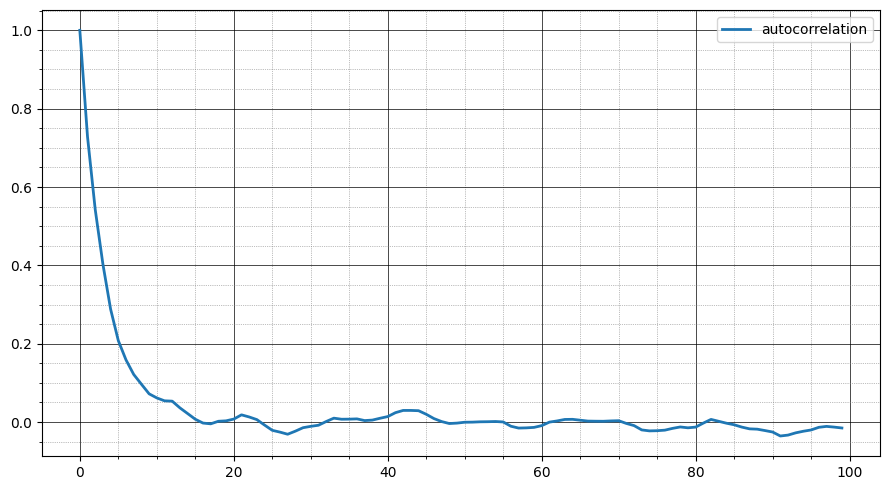

<Figure size 900x500 with 0 Axes>

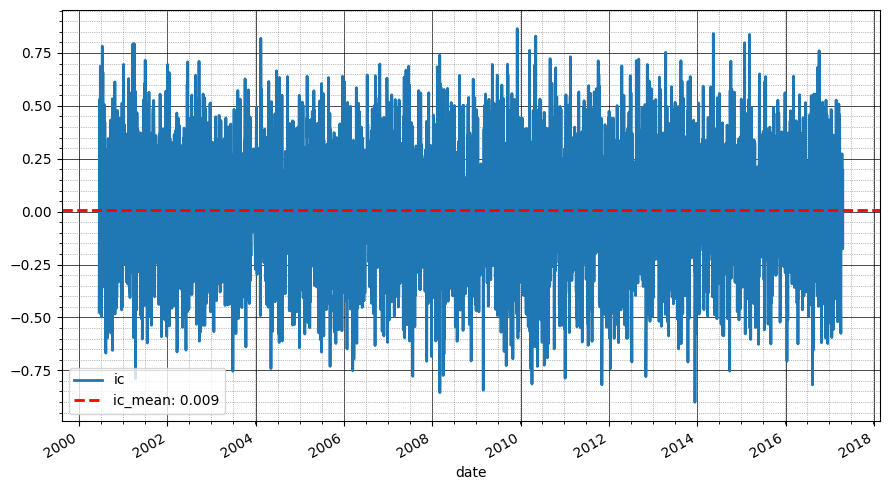

ic 0.004695099528262184


<Figure size 900x500 with 0 Axes>

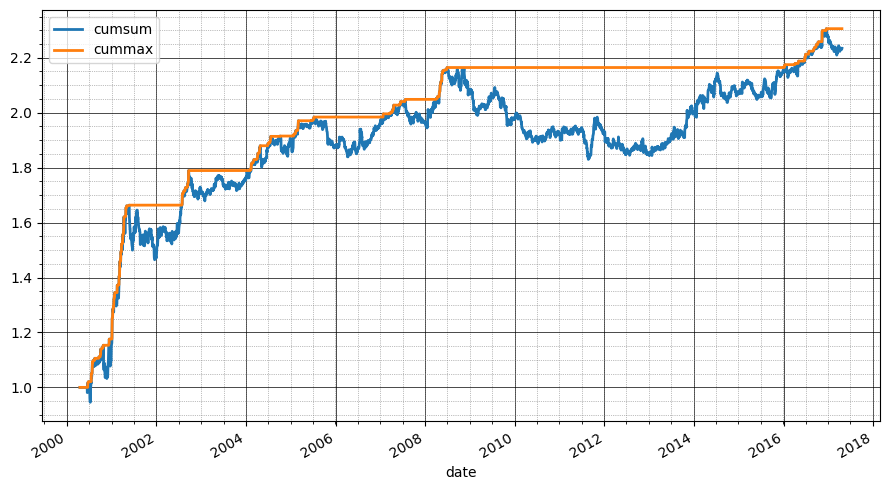

{'mean_turnover': 0.5286758467211922, 'max_dd': 0.15453130109399715, 'mean_dd': 0.05114970495364285, 'roe': 2.8863535348690537, 'mean': 0.07273610907870015, 'vol': 0.11807593216100001, 'sharpe': 0.616011305161854, 'calmar': 1.422024020365731, 'rot': 0.13758167604932972}


In [8]:
plot_analytics(weights_n_data)

# Backtest and quality check

In [9]:
%%time
weights_and_market_data = weights_n_data.to_pandas().set_index(keys)
covariances_path = None

dates, weights, errors = backtest(
    weights_and_market_data=weights_and_market_data,
    covariances_path=covariances_path,
    ptfo_params=ptfo_params,
    build_objective=build_objective_alpha_tracker_with_costs,
    logger=logger,
)

/home/tibo/env/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
2024-04-18 16:59:24 | WARNING  | On day 2009-12-15 00:00:00, the optimization problem failed to solve. The weights will be filled forward.


CPU times: user 1min 52s, sys: 760 ms, total: 1min 53s
Wall time: 1min 52s


In [10]:
%%time
optimized_weights, optimized_weights_ytd, errors = optimized_weights_and_errors_to_pd(dates, weights, errors)

CPU times: user 1.7 s, sys: 4.97 ms, total: 1.71 s
Wall time: 1.71 s


In [11]:
%%time
quality_check = prepare_data_for_backtest_check(weights_and_market_data, optimized_weights, optimized_weights_ytd)
quality_check.loc[:, 'adv_traded'] = quality_check['turnover'] / quality_check['volume_smoothed'] * ptfo_params['aum']

CPU times: user 3.2 s, sys: 1.96 s, total: 5.16 s
Wall time: 5.16 s


0.9658531283208964


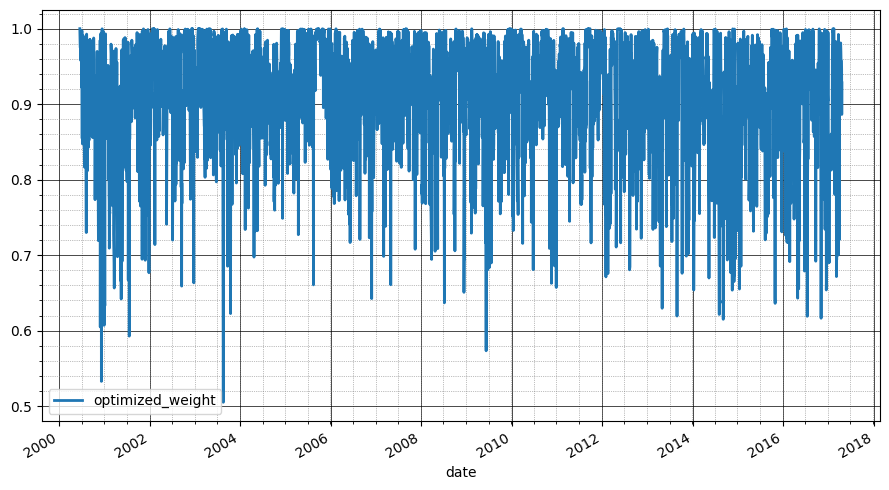

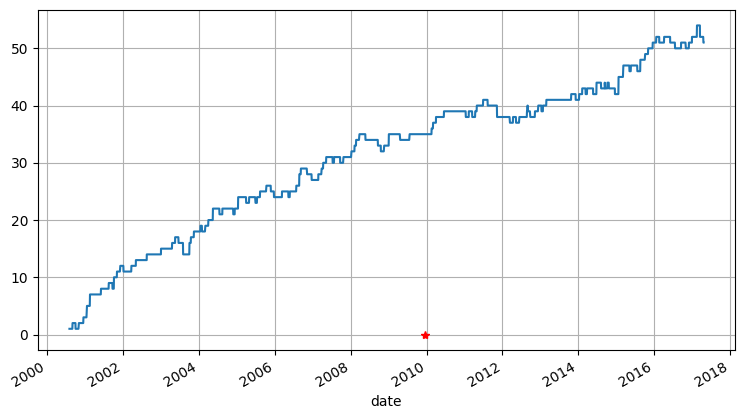

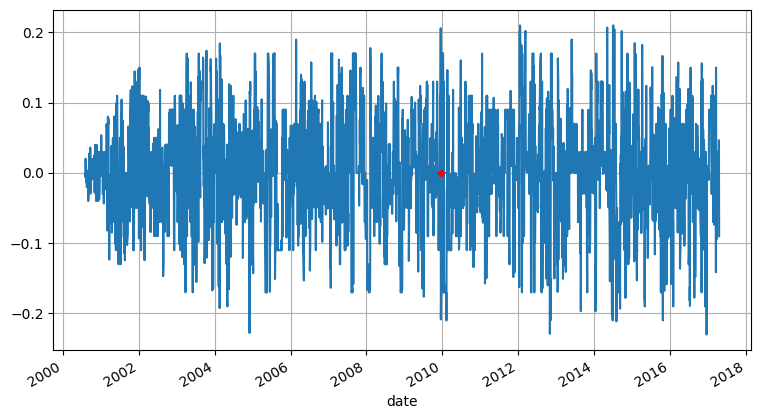

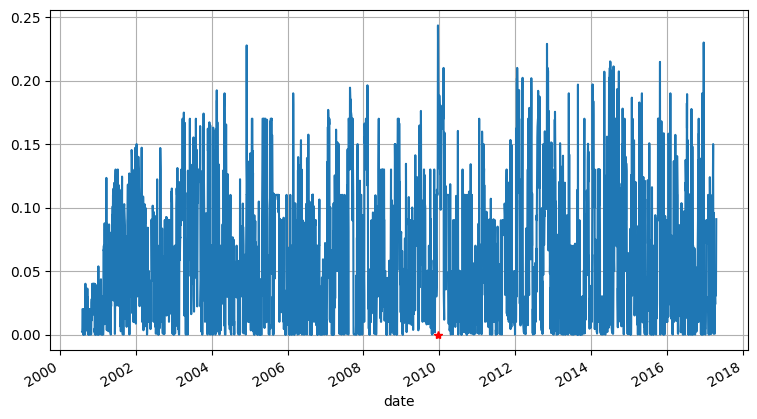

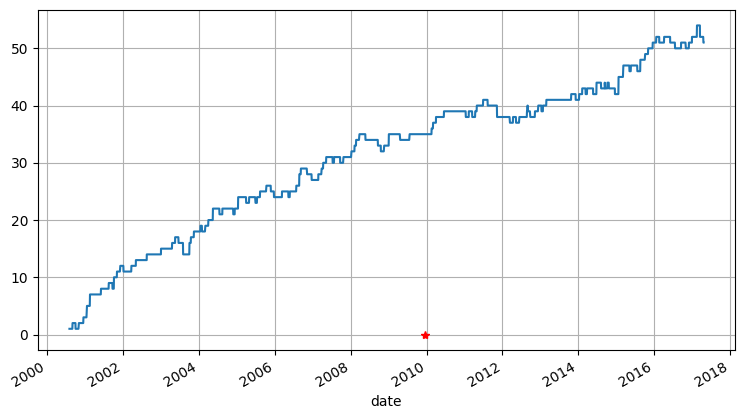

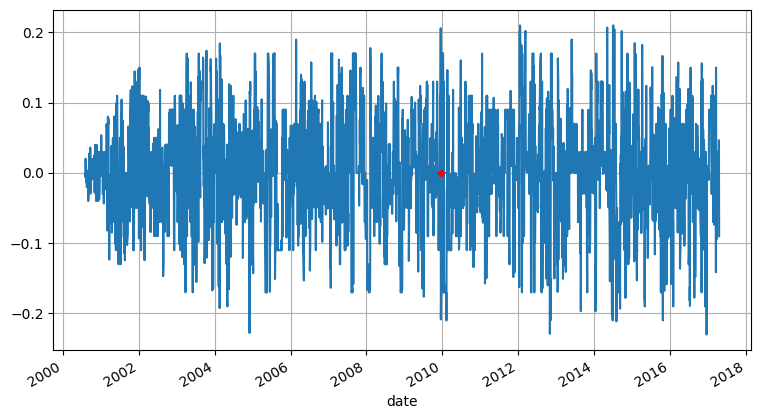

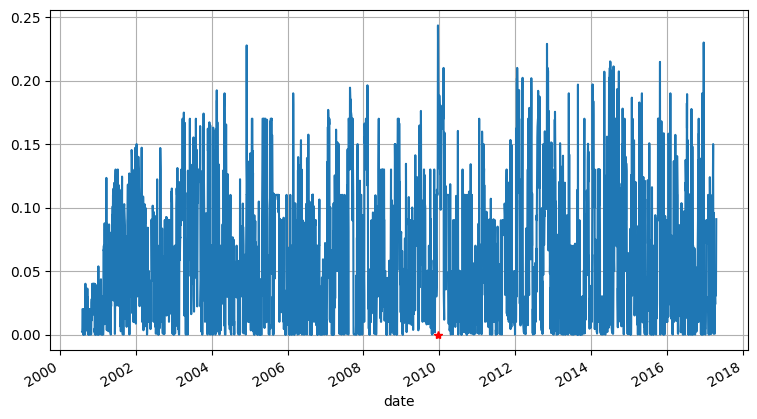

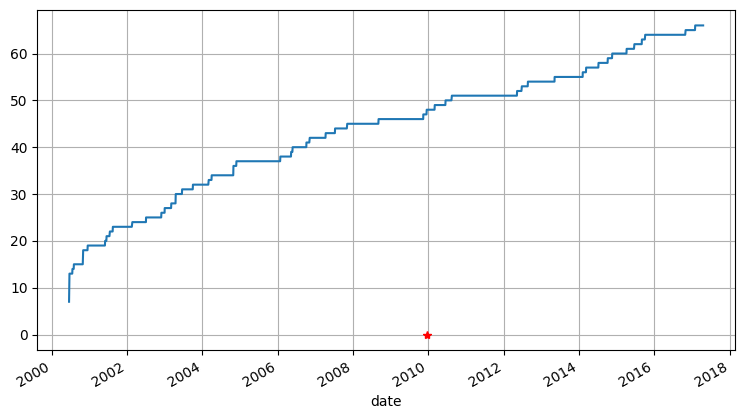

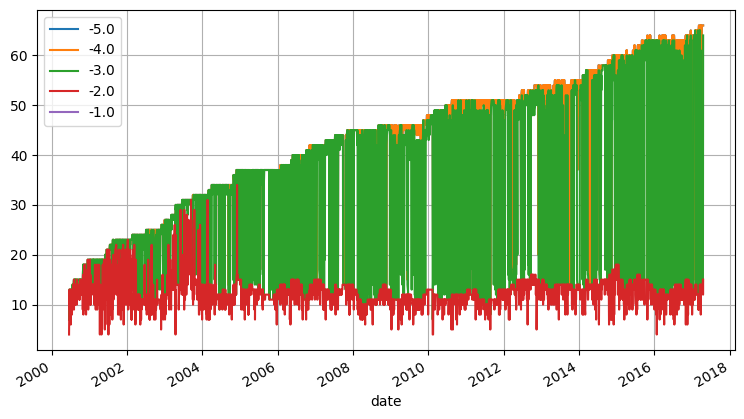

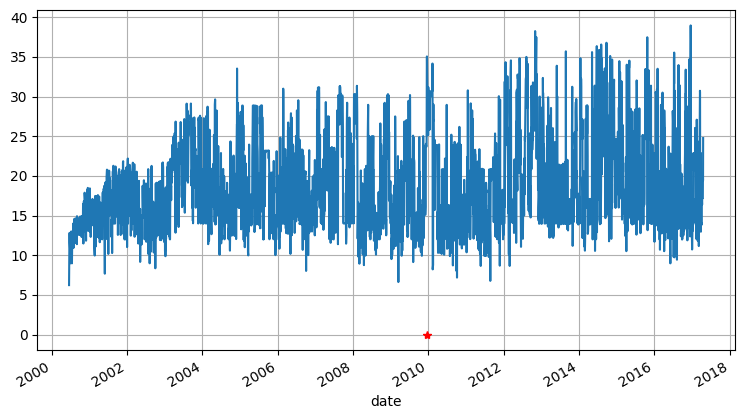

max_leverage


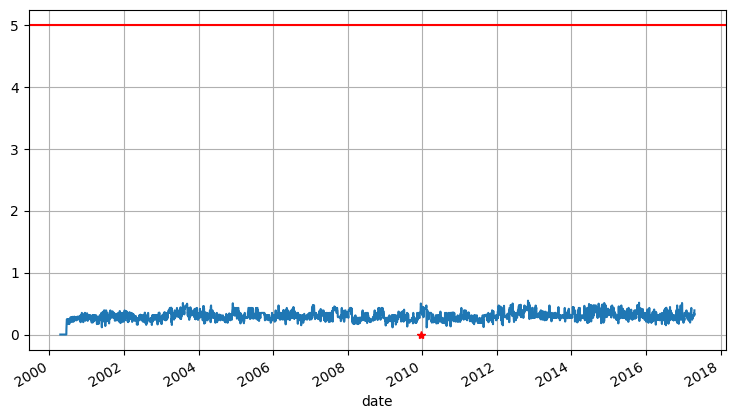

min_abs_weight


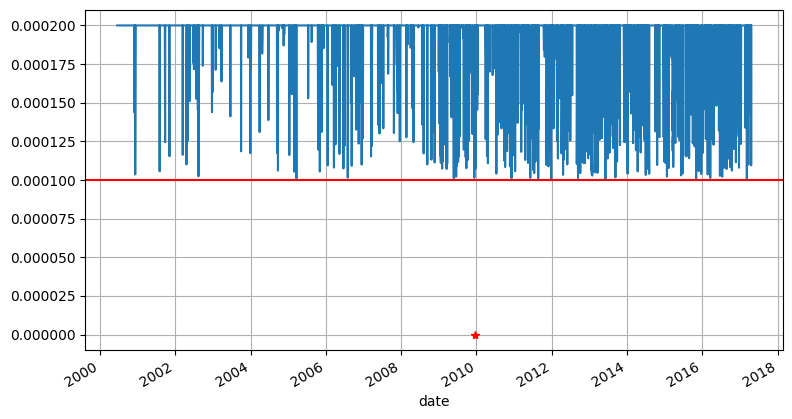

weight_bounds


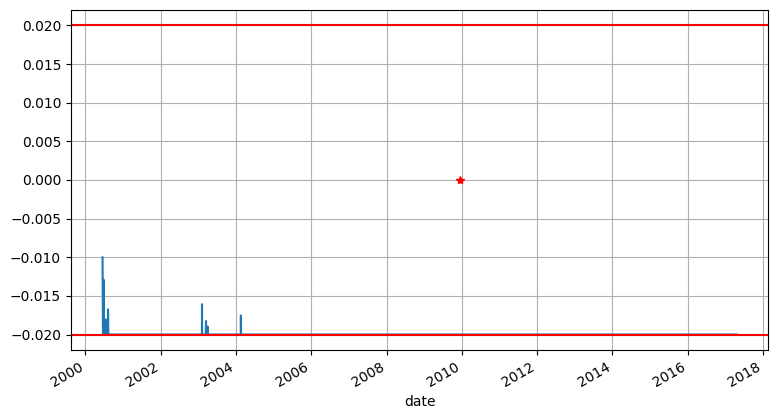

weight_bounds


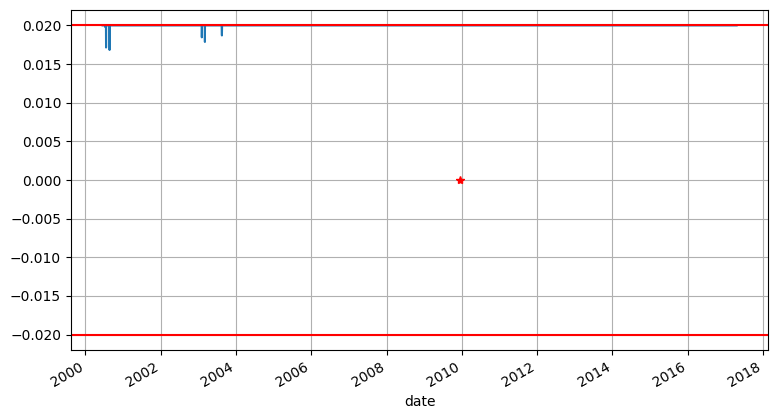

prop_adv


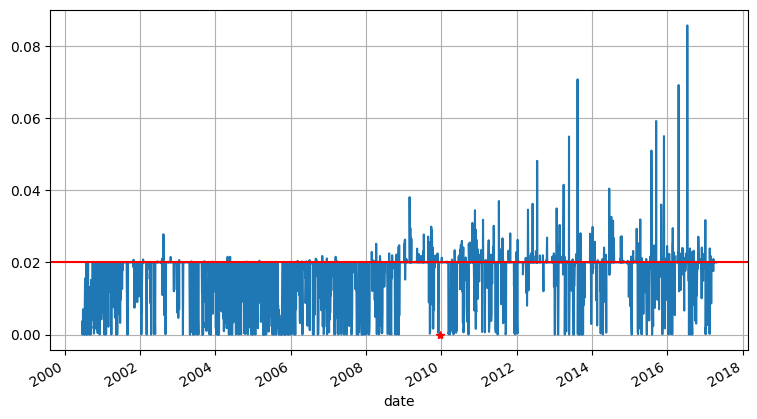

net_bounds


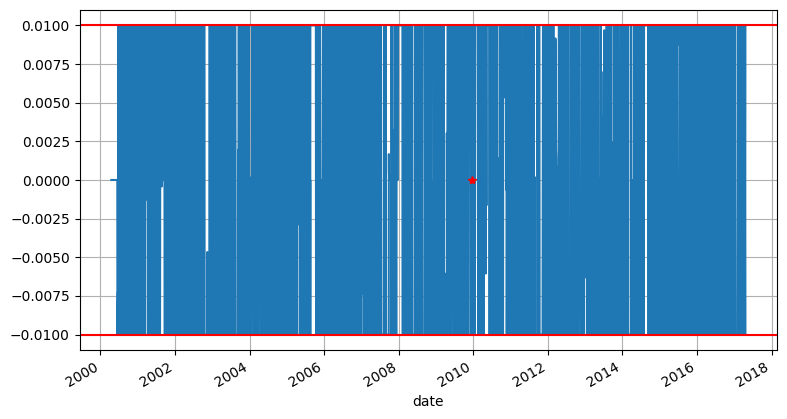

In [12]:
plot_backtest_quality_checks(quality_check, errors, ptfo_params)

# Optimized weights analytics

In [13]:
cols = ['optimized_weight', 'price', 'cost_shorting', 'cost_transaction', 'cost_market_impact']
optimized_weights_n_data_pl = pl.DataFrame(
    quality_check
    .loc[:, cols]
    .reset_index()
    .rename(columns={'optimized_weight': 'weight'})
)
optimized_weights_n_data_pl.select(pl.col([pl.Float32, pl.Float64]).is_nan().sum())

weight,price,cost_shorting,cost_transaction,cost_market_impact
u32,u32,u32,u32,u32
0,0,0,0,0


<Figure size 900x500 with 0 Axes>

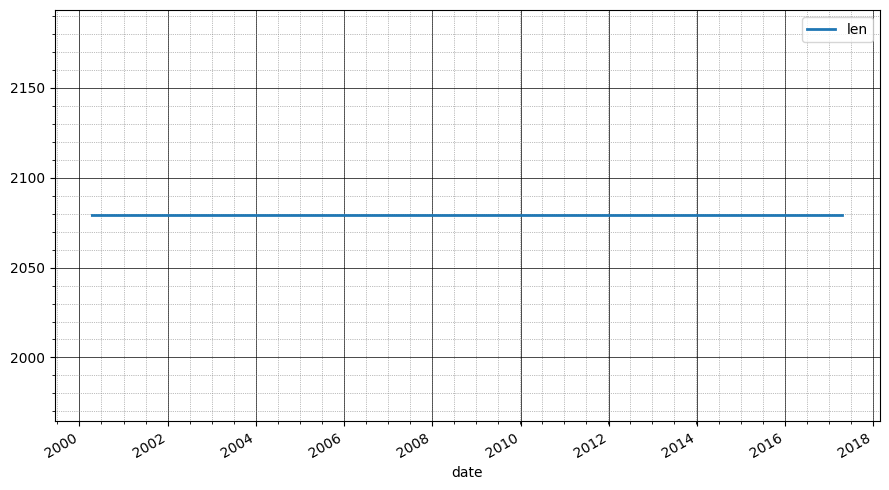

<Figure size 900x500 with 0 Axes>

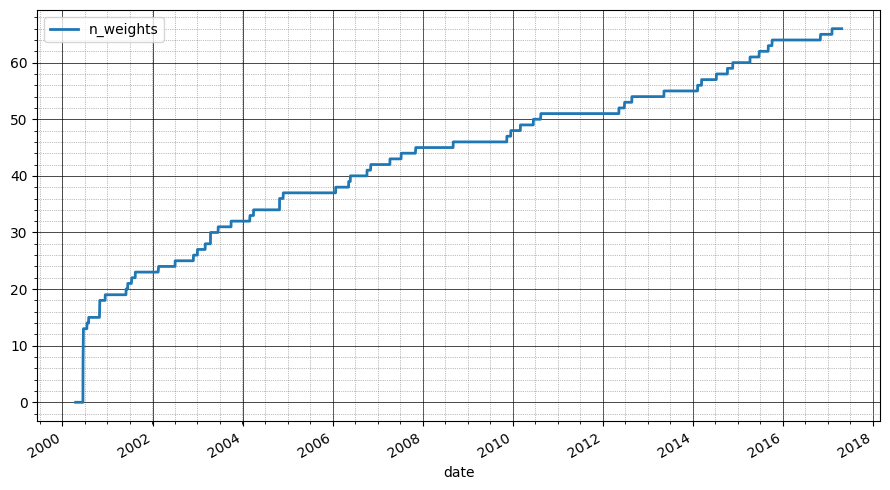

<Figure size 900x500 with 0 Axes>

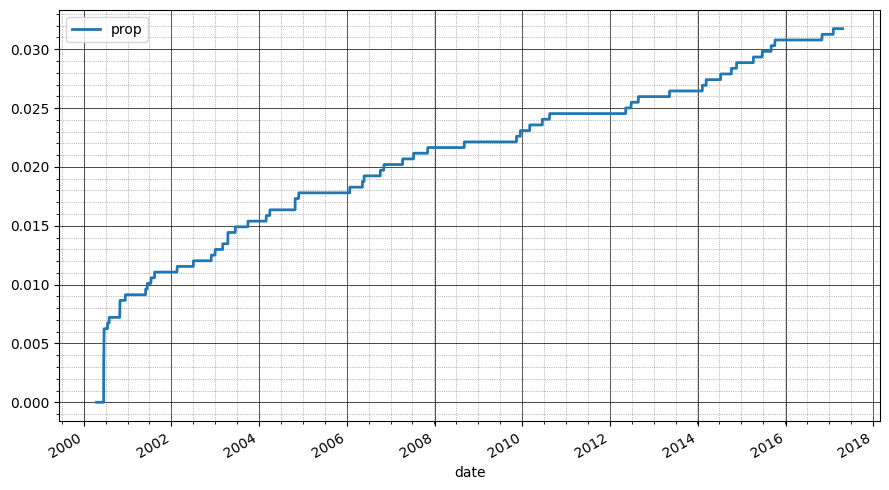

<Figure size 900x500 with 0 Axes>

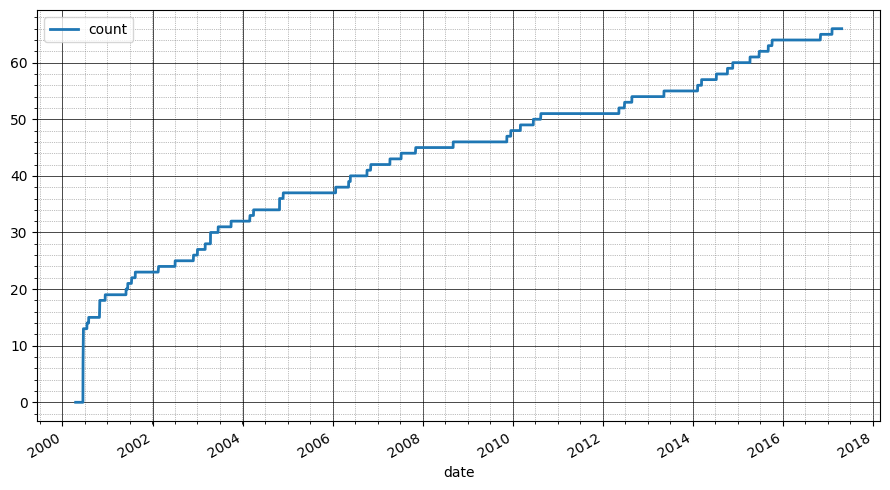

<Figure size 900x500 with 0 Axes>

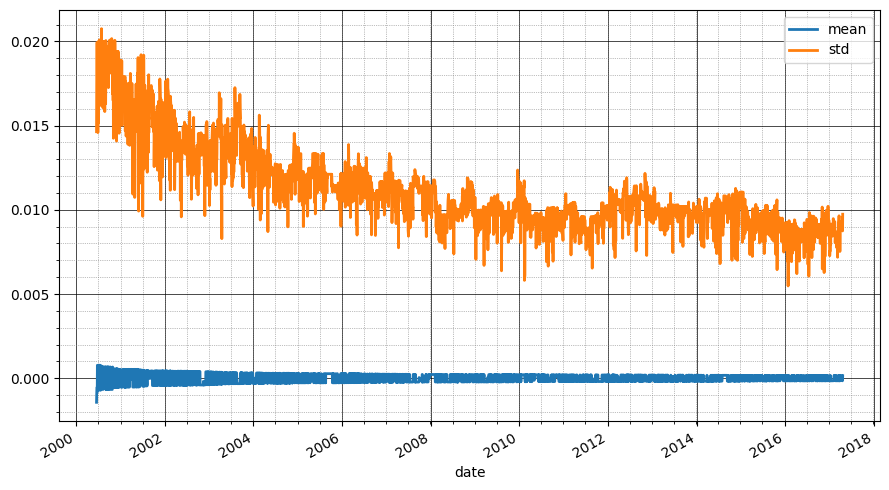

<Figure size 900x500 with 0 Axes>

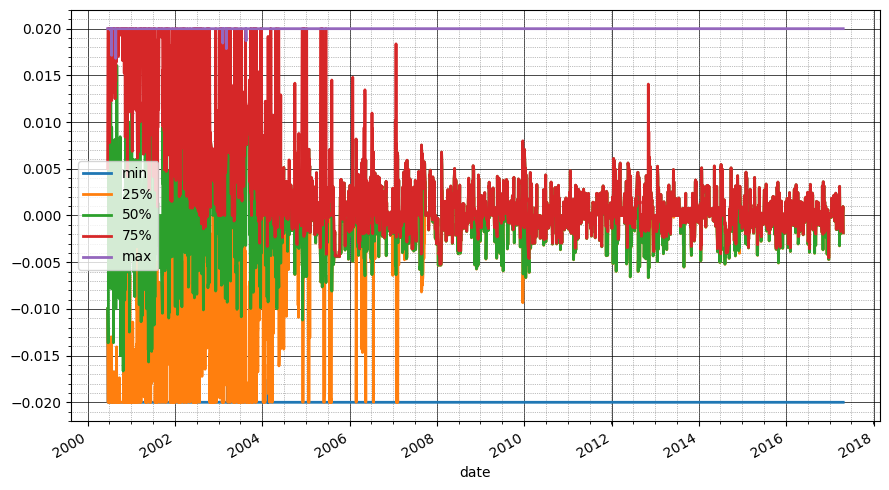

<Figure size 900x500 with 0 Axes>

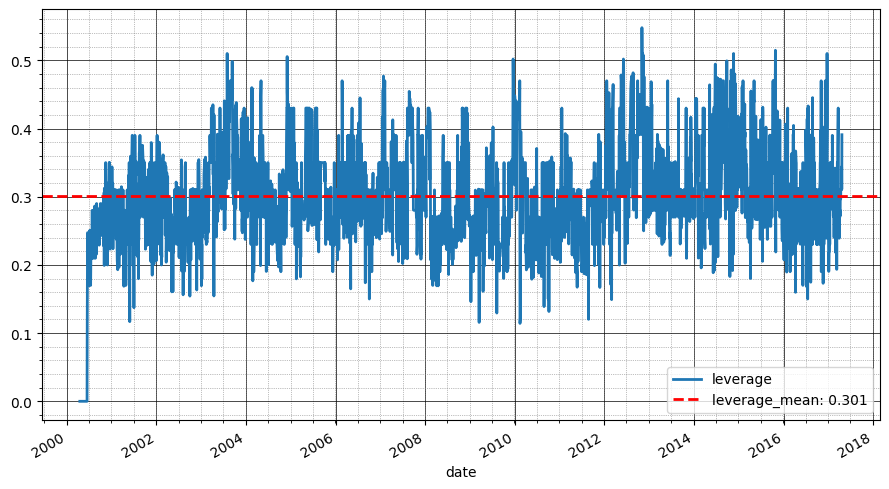

<Figure size 900x500 with 0 Axes>

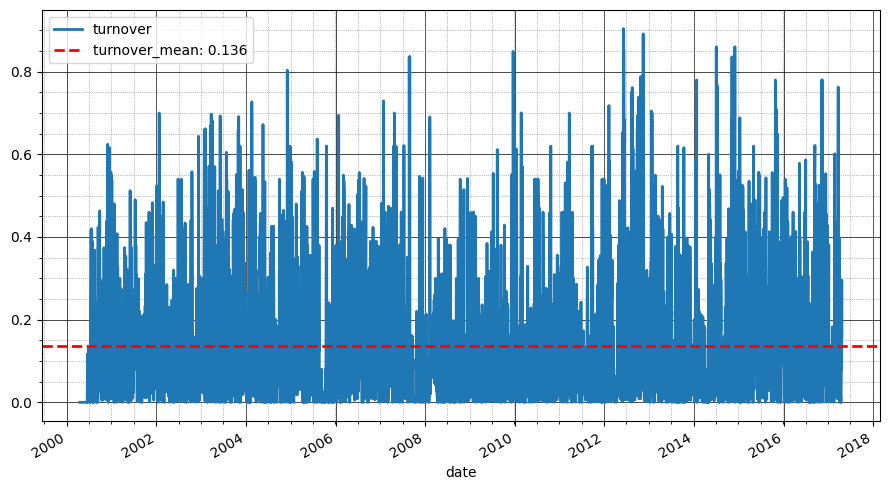

<Figure size 900x500 with 0 Axes>

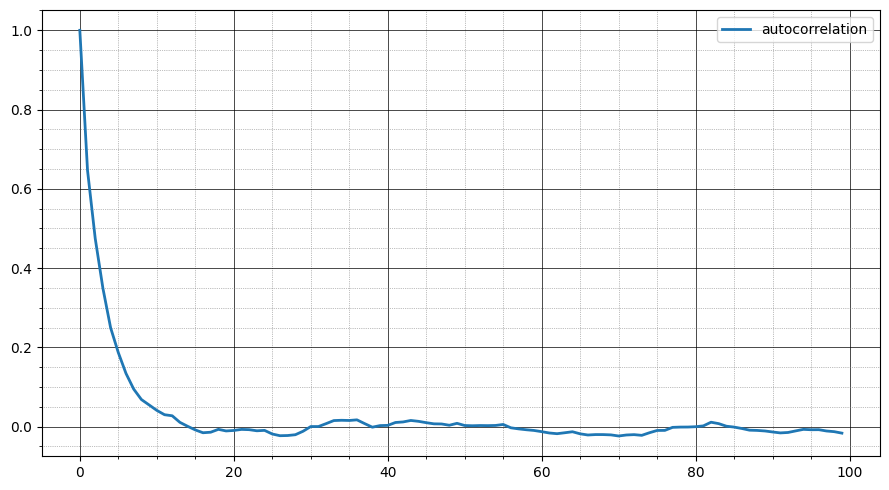

<Figure size 900x500 with 0 Axes>

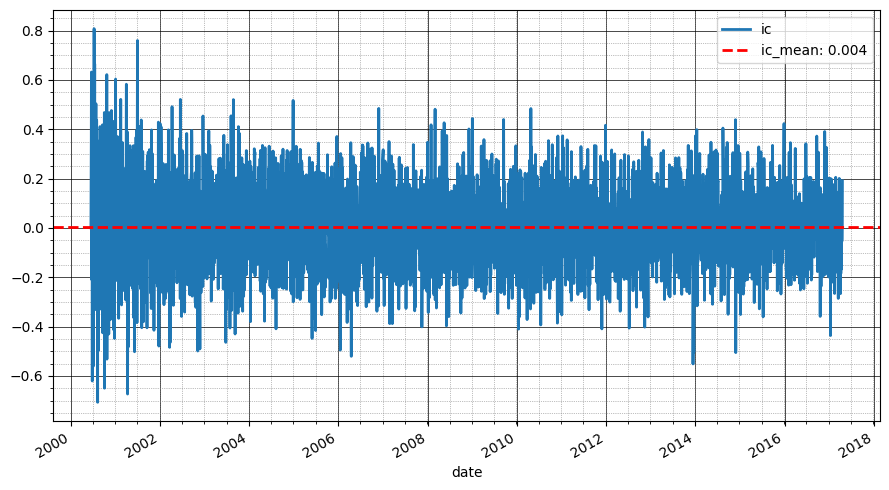

ic 0.004069252193791718


<Figure size 900x500 with 0 Axes>

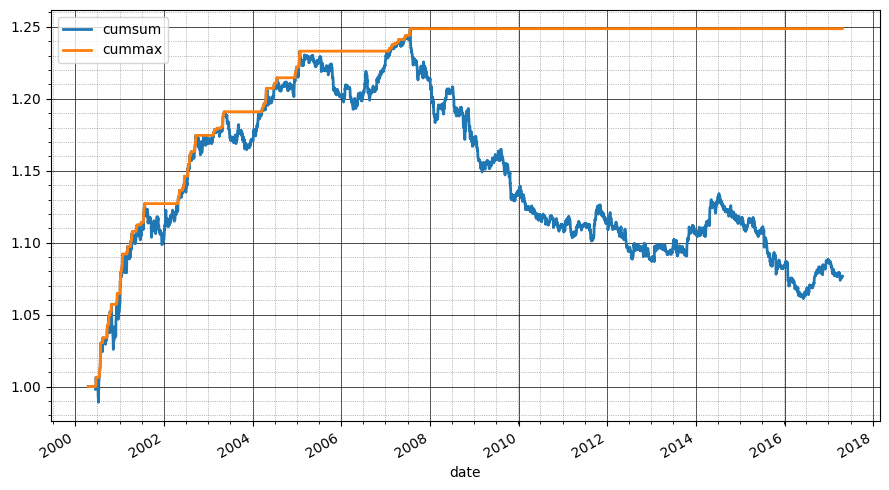

{'mean_turnover': 0.136352667164346, 'max_dd': 0.1501682258724238, 'mean_dd': 0.06176702853823169, 'roe': 0.17936552848955142, 'mean': 0.004520011317936696, 'vol': 0.026362151169701115, 'sharpe': 0.17145836426018576, 'calmar': 0.07317838375758942, 'rot': 0.03314941623025769}


In [14]:
plot_analytics(optimized_weights_n_data_pl)